In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Quantum neural networks


Quantum neural networks (QNNs) are a set of machine learning models that utilize the principles of quantum mechanics but bear close resemblance to classical artificial neural networks (ANNs). Quantum deep learning is a very active area of research and some fundamental concepts have emerged over the last few years. Considering the complexities of training deep neural networks, we will explore how neural network-based algorithms might benefit from quantum mechanics. 

Though there are similarities in classical and quantum neural network approaches, some care needs to be taken while implementing neural networks on quantum hardware. For example, the implementation of nonlinear activation functions prevelant in classical neural networks on quantum hardware is not trivial due to the intrinsically linear nature of quantum operations. Another consideration for quantum computing is the no-cloning theorem, which hinders the process of copying the output from one neuron to multiple neurons in the next layer; this is an essential feature of the classical neural network.

Quantum neural networks refer to a distinct set of concepts, ranging from a quantum algorithm that simulates the behavior of classical perceptrons to parameterized quantum circuits (PQCs), whose parameters can be learned for a particular task. In this notebook, we provide a brief overview of these concepts while emphasizing the currently accepted definition of QNN based on PQCs. 

## QNN architectures

Similar to the field of classical neural networks, there are a variety of QNN architectures. Here, we briefly cover some of the key architectures.

### Quantum perceptron models 

Single artificial neurons, also known as perceptrons, are the basic building blocks of artificial neural networks. Historically, the research on quantum models for perceptrons was focused on emulating their nonlinear properties using quantum circuits.<sup>1</sup> This is especially challenging given the linear nature of quantum gate operations. In more recent proposals, however, variational unsampling techniques are used for training and for finding adaptive quantum circuit implementations of perceptrons.<sup>2</sup> Connecting these quantum versions of perceptron units, models for artificial neural networks are built and trained on superconducting quantum devices. 

<img src="figs/q_perceptron.png" alt="drawing" width="500"/>

### PQCs as QNNs 

The term “quantum neural network” is often used interchangably with variational circuits or PQCs. The most general and currently accepted definition of QNN is a PQC whose structure is modeled after the architecture of classical neural networks.<sup>3</sup> We define a QNN as a PQC whose variational ansatz contains multiple repetitions of self-similar layers of operations, that is:

$$U_{QNN}({\theta}) = \prod U_i(\theta_i)W_i$$

$$U_{QNN}({\theta}) = U_L(\theta_L)W_L \dots U_1(\theta_1)W_1.$$

Here, $U_i(\theta_i)$ refer to parameterized quantum gates and $W_i$ are non-parametric (fixed) quantum gates. $L$ is the number of layers. As mentioned earlier, the linear nature of quantum gates is insufficient for approximating any arbitrary function. To compensate for this limitation of the quantum neural networks and to inject the nonlinearities into it, data can be uploaded at multiple points in a network—for example, $S_1(x), S_2(x), \dots, S_L(x)$—as shown in the diagram below. This technique is referred to as *data-reuploading*.<sup>4</sup> The diagram shows the most general structure of the quantum neural network based on the idea of parametric quantum circuits.

<img src="figs/general_qnn.png" alt="drawing" width="500"/>

<!-- ### 2.3 Kernel methods (?) -->

### Generative models

In contrast to regression or classification problems, the goal of generative models is to learn the probabilty distribution and base the training samples on that data. The model generates samples of the data according to the learned probability distribution. A well-known example from classical machine learning is the generative adverserial network (GAN). GAN is built from two components: a *generator* and a *discriminator*. These building blocks are programmed to compete against each other to make the generator learn the underlying distribution and generate samples that the discriminator cannot discriminate from the training sample.

Another class of generative models based on probabilisic neural networks are called Boltzmann machines (BMs). They are Ising model-inspired machine learning models trained to learn various probability distributions. Quantum versions of the BMs are built by replacing the classical nodes with quantum nodes and by replacing the classical Hamiltonians with quantum Hamiltonians. Variational quantum Boltzmann machine (VarQBM) based on variational quantum imaginary time evolution has also been proposed recently and is implemented on near-term quantum devices.<sup>5</sup>

### Quantum convolutional neural network

A quantum convolutional neural network (QCNN) is a quantum machine learning model, and its architecture is formulated on classical convolutional neural networks (CNNs).<sup>6</sup> A QCNN consists of:
- Repeated application of convolutional layers (CLs): Here, convolutions are operations performed on a subset of qubits—they are parameterized unitary rotations. 
- Repeated application of pooling layers (PLs): CLs are followed by PLs, which are implemented by measuring a subset of qubits. The measurement results are then used to control subsequent operations. 
- The above layers are ultimately followed by a fully-connected layer (FCL): FCL is a multi-qubit operation on all the remaining qubits before the final measurement (or else, operation $O$).

<img src="figs/convqnn.png" alt="drawing" width="400"/>

## Create a QNN

In this section, we will build a QNN from the basic elements in Qiskit. In particular, we will construct a *variational quantum classifier* containing two components: a *data encoding layer* (feature map) and a *trainable parametric circuit block* (variational form).

In [2]:
# Import necessary libraries
import numpy as np
import copy
import matplotlib.pyplot as plt

In [3]:
# Import scikit-learn utility functions
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Import qiskit functionalities
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import QuantumRegister, ClassicalRegister

In [5]:
# Create a dataset from make_classification function
X, y = make_classification(n_samples=50, n_features=4, 
                           n_informative=4, n_redundant=0, random_state=10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [6]:
# Scaling features from -pi to pi
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# size of the circuit
N_f = X_train.shape[1]

We create two essential building blocks of a QNN:
1. A data encoding layer (feature map)
2. A trainable parametric circuit block (variational form)

In [8]:
# Build a feature map 

def feature_map(X):
    "Builds a feature map"

    q = QuantumRegister(N_f)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    for i, x in enumerate(X):
        qc.rx(x, i)

    return qc, c

In [9]:
# Build a trainable variational form or ansatz

def variational_form(qc, theta):
    "Trainable variational circuit"
    
    # First layer of parametric gates
    for i in range(N_f):
        qc.ry(theta[i], i)

    # Second layer of non-parametric, entangling gates
    for i in range(N_f - 1):
        qc.cx(i, i + 1)
    qc.cx(N_f - 1, 0)
    
    # Third layer of parametric gates
    for i in range(N_f):
        qc.ry(theta[N_f + i], i)
    
    return qc

With these two building blocks, we now define a generic QNN:

In [10]:
# Define a quantum neural network

def quantum_nn(X, theta, shots=2048, simulator=True):
    "Quantum Neural Network"

    qc, c = feature_map(X)
    qc = variational_form(qc, theta)
    qc.measure(0, c)

    backend = Aer.get_backend('qasm_simulator')
    job =  backend.run(qc, run_options={'shots': shots})
    result = job.result()
    counts = result.get_counts()
    return counts['1']/shots

In [11]:
# Select a loss function
def loss_fn(prediction, target):    
    "Log-loss function"
    
    y, p = target, prediction
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

In [12]:
# Define gradient procedure to optimize parameters in QNN

def gradient(X_, y_, theta, delta=0.05):
    "Calculates the gradient"
    
    grad = []
    
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        pred1 = quantum_nn(X_, dtheta)
        pred2 = quantum_nn(X_, theta)
        
        grad.append(
            (loss_fn(pred1, y_) - loss_fn(pred2, y_)) / delta
        )
        
    return np.array(grad)

In [13]:
# Definte accuracy metric

def accuracy(X, y, theta, threshold=0.5):
    counter = 0
    for X_i, y_i in zip(X, y):
        prediction = quantum_nn(X_i, theta)
        
        if prediction < threshold and y_i == 0:
            counter +=1
        elif prediction > threshold and y_i == 1:
            counter +=1 
    return counter/len(y)

In [14]:
eta = 0.005
loss_list = []
theta = np.ones(2 * N_f)

In [15]:
print('Epoch \t Loss \t Training Accuracy')

for i in range(100):
    
    loss_tmp = []
    
    for X_i, y_i in zip(X_train, y_train):
    
        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss_fn(prediction, y_i))
        theta -= eta * gradient(X_i, y_i, theta)
    
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, y_train, theta)
    
    if i%10 == 0:
        print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

Epoch 	 Loss 	 Training Accuracy
0 	 0.852 	 0.545
10 	 0.831 	 0.545
20 	 0.821 	 0.545
30 	 0.817 	 0.545
40 	 0.796 	 0.545
50 	 0.788 	 0.545
60 	 0.783 	 0.545
70 	 0.782 	 0.545
80 	 0.774 	 0.545
90 	 0.772 	 0.545


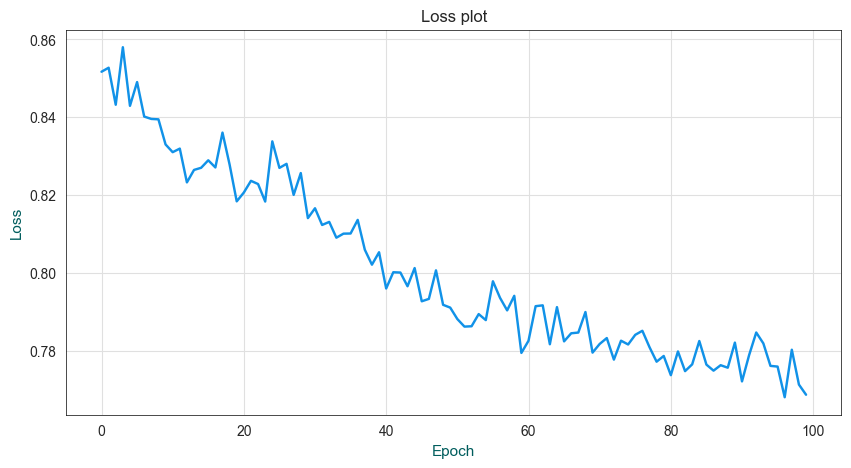

In [16]:
plt.figure(figsize=(10,5))
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.grid()
plt.show()

## Built-in QNNs in Qiskit


The [`qiskit-machine-learning`](https://github.com/Qiskit/qiskit-machine-learning) library provides functions to create QNN architectures. There are two primary ways to build a neural network in Qiskit: `EstimatorQNN` and `SamplerQNN`.

1. [`EstimatorQNN`](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): A neural network implementation based on the Estimator primitive.
2. [`SamplerQNN`](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): A neural network implementation based on the Sampler primitive.

Variational quantum classifier (`VQC`) is a special case of `SamplerQNN`. Below, we use the built-in `VQC` class, similar to the one we created in the previous section.

In [17]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler

We create one-hot encoding of the target variable.

In [18]:
y_train_oh = np.zeros((len(y_train), 2))
for i in range(len(y_train)):
    y_train_oh[i, y_train[i]] = 1

In [19]:
y_test_oh = np.zeros((len(y_test), 2))
for i in range(len(y_test)):
    y_test_oh[i, y_test[i]] = 1

### Choose the ansatz and feature map for `VQC`

In [20]:
feature_dim = X_train.shape[1]

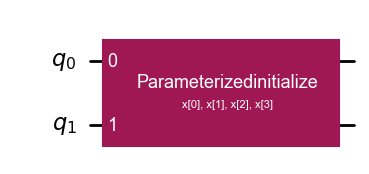

In [21]:
feature_map = RawFeatureVector(feature_dimension=feature_dim)
feature_map.draw('mpl')

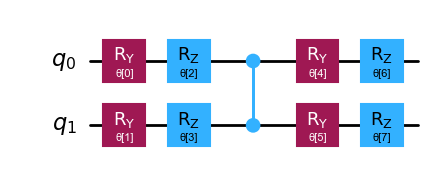

In [22]:
ansatz = TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=1)
ansatz.decompose().draw('mpl')

In [23]:
# Setting the seed for reproducability
seed = 1376
algorithm_globals.random_seed = seed


sampler = Sampler()

# Instantiate VQC using ansatz, feature_map, optimizer
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
    sampler = sampler
)

In [24]:
vqc.fit(X_train, y_train_oh)
score = vqc.score(X_test, y_test_oh)

In [25]:
print('Testing accuracy: {:0.2f}'.format(score))

Testing accuracy: 0.76


### Classical benchmark

In [26]:
cmodel = SVC(kernel='poly')
cmodel.fit(X_train, y_train)
c_score = cmodel.score(X_test, y_test)
print('Testing accuracy classical SVM: {:0.2f}'.format(c_score))

Testing accuracy classical SVM: 0.76


## References

1. <a id='Cao2017'></a>Yudong Cao, Gian Giacomo Guerreschi, and Alán Aspuru-Guzik. “Quantum Neuron: An Elementary Building Block for Machine Learning on Quantum Computers.” arXiv:1711.11240. November 30, 2017. https://arxiv.org/abs/1711.11240.

2. <a id='Tacchino2021'></a>Francesco Tacchino et al. “Variational Learning for Quantum Artificial Neural Networks.” *IEEE Transactions on Quantum Engineering*, vol. 2 (2021). https://arxiv.org/abs/2103.02498.

3. <a id='Mangini2021'></a>Stefano Mangini et al. “Quantum Computing Models for Artificial Neural Networks.” *Europhysics Letters*, vol. 134, no. 1 (2021): 10002. https://arxiv.org/abs/2102.03879.

<!-- <a id='Hubregtsen2020'></a> 4. Hubregtsen, Pichlmeier, Stecher, Bertels, [Evaluation of Parameterized Quantum Circuits: on the relation between classification accuracy, expressibility and entangling capability](https://arxiv.org/abs/2003.09887), 2020. https://arxiv.org/abs/2003.09887 -->

4. <a id='Perez_Salinas2019'></a>Adrián Pérez-Salinas et al. “Data Re-uploading for a Universal Quantum Classifier.” *Quantum*, vol. 4 (2020): 226. https://arxiv.org/abs/1907.02085.

5. <a id='Zoufal2020'></a>Christa Zoufal, Aurélien Lucchi, and Stefan Woerner. “Variational Quantum Boltzmann Machines.” *Quantum Machine Intelligence*, vol. 3, no. 7 (2021). https://arxiv.org/abs/2006.06004.

6. <a id='IrisCong2018'></a>Iris Cong, Soonwon Choi, and Mikhail Lukin. “Quantum Convolutional Neural Networks.” *Nature Physics*, vol. 15 (2019): 1273–1278. https://arxiv.org/abs/1810.03787.


<!-- 4. Abbas, Sutter, Zoufal, Lucchi, Figalli, Woerner, “The power of quantum neural networks.” National Computer Science, Oct 30, 2020. https://arxiv.org/abs/2011.00027 -->

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>